In [50]:
from graphviz import Digraph
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def with_label(value, label):
    value._label = label
    return value

class Value:
    def __init__(self, value, prev=(), op='', label=''):
        self._label = label
        self.data = value
        self._prev = set(prev)
        self._op = op
        self._grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = Value.get_value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self._grad += 1. * out.grad
            other._grad += 1. * out.grad
        out._backward = backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = Value.get_value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self._grad += other.data * out.grad
            other._grad += self.data * out.grad
        out._backward = backward

        return out

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self._grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float are supported on pow"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self._grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self._grad += (1 - t**2) * out.grad
        out._backward = backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def _build(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    _build(child)
                topo.append(v)

        _build(self)

        self._grad = 1
        for node in reversed(topo):
            node._backward()

    @staticmethod
    def get_value(x):
        if isinstance(x, Value):
            return x
        return Value(x, label=f'scalar({x})')

    @property
    def label(self):
        return self._label or '<unknown>'

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    @property
    def grad(self):
        return self._grad


In [52]:
class Neuron:
    def __init__(self, inputs_len):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(inputs_len)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # w * x -> dot product
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

In [53]:
x = [2., 3.]
n = Neuron(2)
n(x)

Value(data=0.01748305707955423, label=<unknown>)

In [54]:
class Layer:
    def __init__(self, inputs_len, outputs_len):
        self.neurons = [Neuron(inputs_len) for _ in range(outputs_len)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [55]:
x = [2., 3.]
l = Layer(2, 3)
l(x)

[Value(data=0.9904825194248197, label=<unknown>),
 Value(data=0.9897288533702636, label=<unknown>),
 Value(data=-0.9712567930397031, label=<unknown>)]

In [56]:
class MLP:
    def __init__(self, inputs_len, outputs_lens):
        sz = [inputs_len] + outputs_lens
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(outputs_lens))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [57]:
# implementing https://929687.smushcdn.com/2633864/wp-content/uploads/2016/08/simple_neural_network_header-768x377.jpg?lossy=1&strip=1&webp=1
# 3 values on input
# 2 layers of 4 neurons
# 1 layer of 1 neuron as output
x = [2., 3., -1.]
m = MLP(3, [4, 4, 1])
m(x)

Value(data=0.23724778026642665, label=<unknown>)

In [58]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for _n in nodes:
        uid = str(id(_n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (_n.label, _n.data, _n.grad), shape='record')
        if _n.op:
            dot.node(name = uid + _n.op, label = _n.op)
            dot.edge(uid + _n.op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

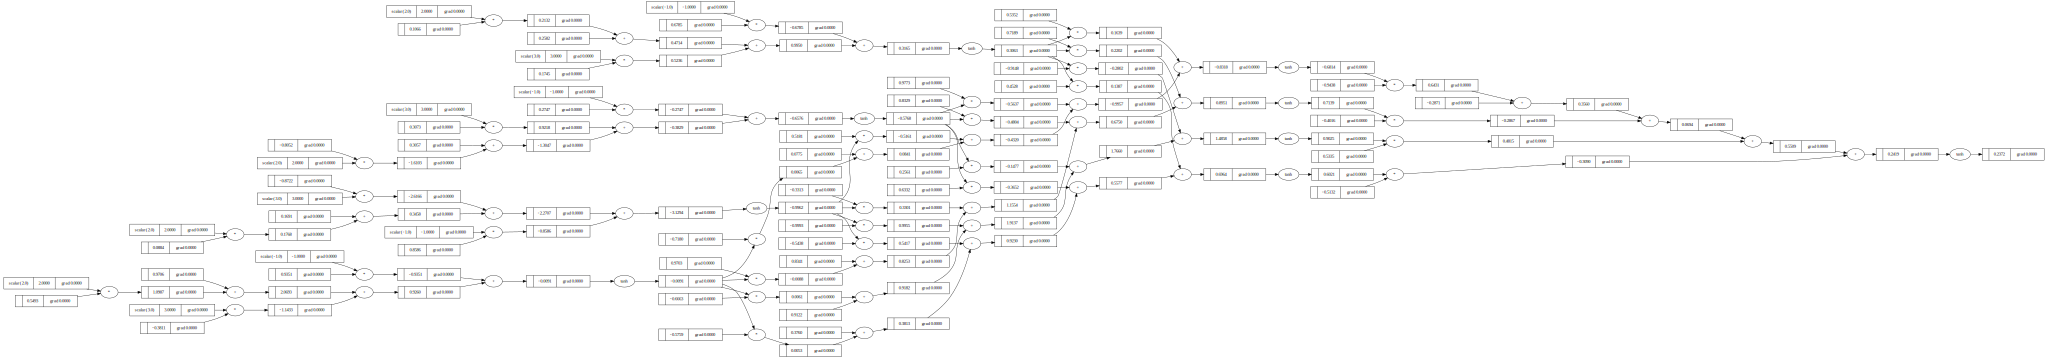

In [59]:
draw_dot(m(x))